In [25]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt


In [26]:

def load_nifti(file_path):
    """ Load a NIfTI image and return a NumPy array. """
    return nib.load(file_path).get_fdata()

def visualize_slices(image_path, label_path, prediction_path, slice_idx=None):
    """ Visualizes a single slice from an MRI scan, ground truth, and prediction. """
    
    # Load images
    image = load_nifti(image_path)
    label = load_nifti(label_path)
    prediction = load_nifti(prediction_path)

    # Default to the middle slice if none provided
    if slice_idx is None:
        slice_idx = image.shape[-1] // 2  # Middle slice in depth

    # Ensure label and prediction are single-channel (choose the max label at each pixel)
    if label.ndim == 4:  # (C, H, W, D)
        label = np.argmax(label, axis=0)  # Collapse to (H, W, D)
    elif label.ndim == 3:  # (H, W, D)
        pass  # Keep as is
    elif label.ndim == 2:  # (H, W)
        slice_idx = None  # Ignore slice index for 2D case

    if prediction.ndim == 4:
        prediction = np.argmax(prediction, axis=0)  # Collapse to (H, W, D)
    elif prediction.ndim == 3:
        pass
    elif prediction.ndim == 2:
        slice_idx = None
    

    print("Label class distribution:", np.bincount(label.flatten().astype(int)))
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # MRI Scan
    if slice_idx is not None:
        axes[0].imshow(image[:, :, slice_idx], cmap="gray")
    else:
        axes[0].imshow(image, cmap="gray")
    axes[0].set_title("MRI Scan")
    axes[0].axis("off")

    # Ground Truth Segmentation (Overlay)
    if slice_idx is not None:
        axes[1].imshow(image[:, :, slice_idx], cmap="gray")
        axes[1].imshow(label[:, :, slice_idx], cmap="jet", alpha=0.5)  # Overlay segmentation
    else:
        axes[1].imshow(label, cmap="jet", alpha=0.5)
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")

    # Model Prediction (Overlay)
    if slice_idx is not None:
        axes[2].imshow(image[:, :, slice_idx], cmap="gray")
        axes[2].imshow(prediction[:, :, slice_idx], cmap="jet", alpha=0.5)  # Overlay prediction
    else:
        axes[2].imshow(prediction, cmap="jet", alpha=0.5)
    axes[2].set_title("Model Prediction")
    axes[2].axis("off")
    
    colorbar = fig.colorbar(axes[2].imshow(prediction[:, :, slice_idx], cmap="jet", alpha=0.5), ax=axes[2])
    colorbar.set_label("Class Index")

    # Show the figure
    plt.show()


Label class distribution: [576297  13527]


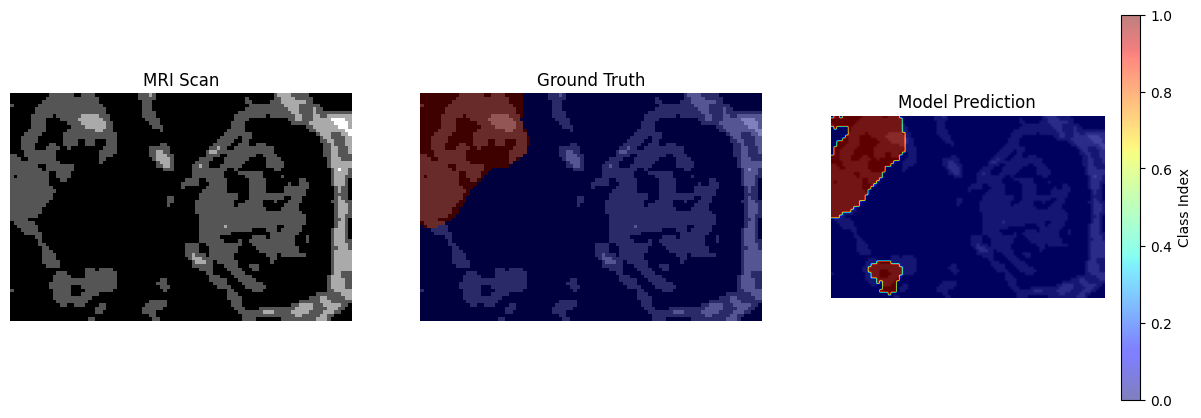

In [29]:
# Set file paths (adjust paths as needed)
image_path = "results/predictions/image_4.nii.gz"
label_path = "results/predictions/label_4.nii.gz"
prediction_path = "results/predictions/prediction_4.nii.gz"

# Visualize a specific slice (e.g., slice 50)
visualize_slices(image_path, label_path, prediction_path, slice_idx=50)